In [11]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 9.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.5/980.5 kB 9.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 10.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
# Equal amounts, so there is no need to normalize
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Basic RNN

In [18]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [19]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                
                                                                                              

In [7]:
# Find the review with the highest number of words
def maxWords(reviewList):
    words = 5000        # Arbitrary value for max words
    for review in reviewList:
        if (len(review.split()) > words):
            words = len(review.split())
            
    return words

In [18]:
reviewList = df['review'].tolist()
words = maxWords(reviewList)
print(words)

5000


In [13]:
# Convert categorical values to numeric using factorize()
sentiment_label = df['sentiment'].factorize()
sentiment_label

(array([0, 0, 0, ..., 1, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

## Preprocessing

In [27]:
# Retrieve all text data from dataset
text = df['review'].values

# Tokenize the words in text and fit to associate the words and labels
tokenizer = Tokenizer(num_words=words)
tokenizer.fit_on_texts(text)

# Identify the size of vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Replace words with their assigned numbers using text_to_sequence()
encoding = tokenizer.texts_to_sequences(text)

# Add padding so sentences can have equal length
pad_sequence = pad_sequences(encoding, maxlen=200)

In [28]:
pad_sequence

array([[3804,    8,    1, ...,  125, 4103,  486],
       [   0,    0,    0, ..., 1977,   69,  221],
       [   0,    0,    0, ...,   63,   16,  350],
       ...,
       [ 299,  368, 1123, ..., 1957,    2,    2],
       [   0,    0,    0, ...,   67,  739,   42],
       [   0,    0,    0, ...,  794,   11,   17]], dtype=int32)

## Text Classifier

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding


embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           3976096   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 3,992,747
Trainable params: 3,992,747
Non-trainable params: 0
____________________________________________

## Training the Model

In [31]:
# Train for 5 epochs with batch size 32 and validation split 20%
history = model.fit(pad_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1250/1250 [==============================] - 182s 144ms/step - loss: 0.4308 - accuracy: 0.7984 - val_loss: 0.2909 - val_accuracy: 0.8784
Epoch 2/5
1250/1250 [==============================] - 178s 142ms/step - loss: 0.2997 - accuracy: 0.8774 - val_loss: 0.2958 - val_accuracy: 0.8721
Epoch 3/5
1250/1250 [==============================] - 180s 144ms/step - loss: 0.2716 - accuracy: 0.8903 - val_loss: 0.3005 - val_accuracy: 0.8829
Epoch 4/5
1250/1250 [==============================] - 179s 143ms/step - loss: 0.2549 - accuracy: 0.8972 - val_loss: 0.2831 - val_accuracy: 0.8840
Epoch 5/5
1250/1250 [==============================] - 175s 140ms/step - loss: 0.2426 - accuracy: 0.9032 - val_loss: 0.3076 - val_accuracy: 0.8822


## Plot Accuracy and Loss

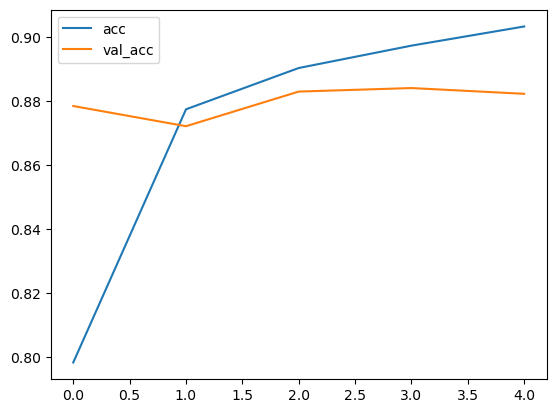

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

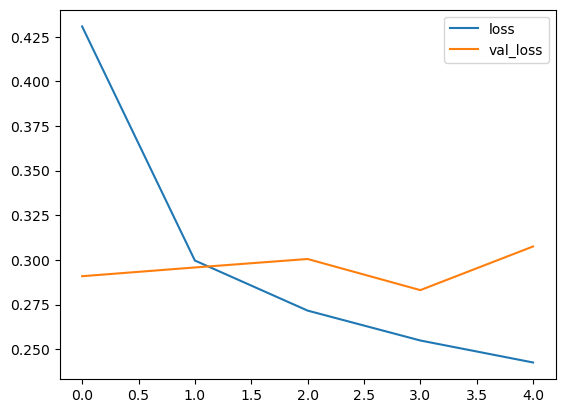

<Figure size 640x480 with 0 Axes>

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

In [34]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "I enjoyed this movie. The actors were very inspirational."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst movie I've ever seen in my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 286ms/step
Predicted label:  positive
1/1 [==============================] - 0s 37ms/step
Predicted label:  negative
